In [253]:
using Pkg
Pkg.activate("..") ## because we have environment files in the parent directory
Pkg.instantiate() ## to download all missing packages


  Activating project at `c:\Users\piotr\Dropbox\WNE\QuantEcon_all\QEcon2023\Code`


In [254]:
# load some packages we will need today
using Distributions, QuantEcon, IterTools, Plots, Optim, Interpolations

In [262]:

function create_ngm_model(; 
    ρ_z=0.75, # log of productivity persistence
    ν_z=0.1, # log of productivity volatility
    b_z=0, # log of productivity intercept
    γ = 2, # curvature parameter of utility function
    α = 0.3, # curvature parameter of production function 
    u = γ == 1 ? x -> log(x) : x -> (x^(1 - γ) - 1) / (1 - γ), # utility function
    f = x -> x^ α, # production function
    δ = 1, # depreciation rate
    F = (x, y) -> y * f(x) + (1 - δ) * x, # available resources
    β=0.96, # discount factor
    N_z=3) # grid size for Tauchen
    mc_z = tauchen(N_z, ρ_z, ν_z, b_z)
    z_vec = exp.(mc_z.state_values)
    return (; ρ_z, ν_z, b_z, γ, α, u, f, F, δ, β, N_z, mc_z, z_vec)
    end

create_ngm_model (generic function with 1 method)

In [267]:
function create_grid();
    N_k = 70
    k_min = 0.01
    k_max = 1
    k_vec= collect(range(k_min, k_max, length=N_k))
    return (; k_vec, N_k)
end

create_grid (generic function with 1 method)

In [264]:

function getW!(W,V,k_vec,z_vec,P)
    for (i, k′) in enumerate(k_vec)
        for (j, z) in enumerate(z_vec)
            W[i,j] = sum(P[j,j′] .* V[i,j′] for j′ in eachindex(z_vec))
        end
    end
return W
end

function vfi(model,grid;tol = 1e-6, maxiter = 1000)
    (; ρ_z, ν_z, b_z, γ, α, u, f, F, δ, β, N_z, mc_z, z_vec) = model
    (; k_vec, N_k) = grid

    P = mc_z.p # transition matrix
    
    V = zeros(N_k,N_z) # initialize value function
    W = similar(V) # initialize W
    σ = similar(V) # initialize policy function
    
    # get W
    getW!(W,V,k_vec,z_vec,P)
    error = 1 + tol
    iter = 1;
    while error > tol && iter < maxiter
        V_new, σ = T_operator(W, model, grid)
        error = maximum(abs.(V_new .- V))
        getW!(W,V_new,k_vec,z_vec,P)
        V = V_new
        
        iter += 1
    end
    return V, σ, error, iter
end


function T_operator(W, model, grid; tol = 1e-10)
    
    (; ρ_z, ν_z, b_z, γ, α, u, f, F, δ, β, N_z, mc_z, z_vec) = model # unpack parameters
    (; k_vec, N_k) = grid

    W_hat = linear_interpolation((k_vec,z_vec),W,extrapolation_bc=Linear()) # linear interpolation of W

    TW = similar(W)
    σ = similar(W)
    for (i, k) in enumerate(k_vec)
        for (j, z) in enumerate(z_vec)
            # solve maximization for each point in (k,z), using k itself as initial condition.
            results = maximize(k′ -> u(F(k,z)-k′) +
                                    β * W_hat(k′,z),
                                    1e-8, 0.5*F(k,z))
            TW[i,j] = maximum(results)
            σ[i,j] = Optim.maximizer(results)
        end
    end
    return TW, σ 
end

T_operator (generic function with 1 method)

In [268]:


model = create_ngm_model()
grid = create_grid()

V, σ, error, iter = vfi(model,grid)

([-55.052861948807816 -40.19063149302123 -31.29736959830208; -52.5849297793251 -38.68543627259993 -30.350661801039543; … ; -46.23177985175932 -34.756282455652055 -27.89074008167816; -46.215328330227656 -34.74585402573494 -27.88429619099742], [0.03869565178465022 0.053043477866508676 0.08173912967521757; 0.05304347830731072 0.07508446587216812 0.1104347833885425; … ; 0.2252173958205706 0.35208185748713383 0.5408695693142154; 0.22554302376461816 0.35434782618414046 0.5456716205761202], 9.75182182116896e-7, 351)

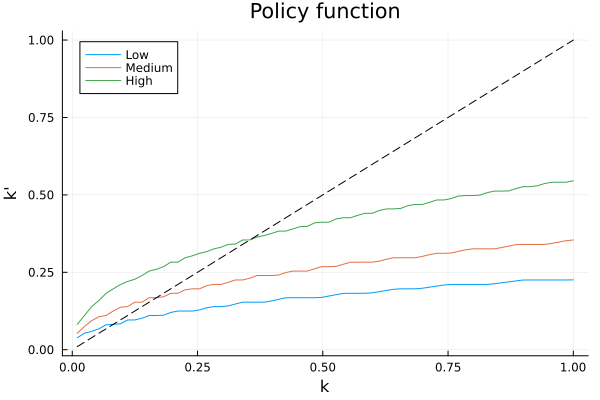

In [269]:
plot(grid.k_vec, σ, label = ["Low" "Medium" "High"], xlabel = "k", ylabel = "k'", title = "Policy function", legend = :topleft)
    plot!(grid.k_vec, grid.k_vec, label = false, linestyle = :dash, color = :black)

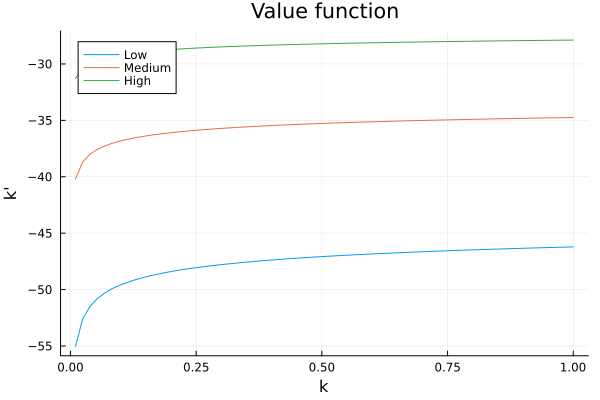

In [270]:
plot(grid.k_vec, V, label = ["Low" "Medium" "High"], xlabel = "k", ylabel = "k'", title = "Value function", legend = :topleft)